# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
cv2.setRNGSeed(seed)

# Fetch from TfRecords

In [8]:
PATH_KAGGLE_DS = "kaggle_dataset"
dataset_df = pd.read_csv(os.path.join(PATH_KAGGLE_DS, "train.csv"))
PATH_TFRECORD_DS = os.path.join(PATH_KAGGLE_DS, "train_tfrecords")
tf_records = dataset_df.file_id.map(lambda x: os.path.join(PATH_TFRECORD_DS, f"{x}.tfrecord")).unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [9]:
with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'r') as f:
    json_str = f.read()
FEATURE_COLUMNS = json.loads(json_str)
FEATURE_COLUMNS[:10]

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9']

In [12]:
# These points represent the hands, elbows, and shoulders.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]

# Facial information isn't necessary, but the nose will serve as a midpoint for normalizing the data, as it is usually located in the middle of the frame.
FPOSE = [0] # Nose as midpoint

# Collecting the indices of certain important/distinct sets of features.
# This can be beneficial during the preprocessing step.
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 0] # Nose

In [13]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [16]:
# The default mapping that came with the dataset was changed:
# padding is represented with the number 0
# start_token is 60
# end_token is 61
with open (os.path.join(PATH_KAGGLE_DS, "character_to_prediction_index.json"), "r") as f:
    char_to_num = json.load(f)
    
char_to_num = {c:char_to_num[c]+1 for c in char_to_num}

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
pad_token_idx = 0
char_to_num[pad_token] = pad_token_idx

start_token = '<'
start_token_idx = 60
char_to_num[start_token] = start_token_idx

end_token = '>'
end_token_idx = 61
char_to_num[end_token] = end_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}

## Preprocess phrase

In [18]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="tf_char_to_num"
)

# Function to decode the characters and pad the phrases
MAX_PHRASE_LEN = 31 + 2 # The start and end token take space as well
def preprocess_phrase(phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    max_len_plus = MAX_PHRASE_LEN + 1
    amount_to_pad = max_len_plus - tf.shape(phrase)[0]
    
    if amount_to_pad > 0:
        phrase = tf.pad(phrase, paddings=[[0, amount_to_pad]], mode = 'CONSTANT', constant_values = pad_token_idx)
    else:
        phrase = phrase[:max_len_plus]

    return phrase

## Preprocess landmark A

In [140]:
FRAME_LEN = 256
def preprocess_landmark_a(x):
    # Select distinct groups
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    # Calculate how many unknown values there are for each hand
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # As fingerspelling gestures only use one hand, the model will only receive the dominant one. (=less NaN values)
    # Also from the pose information, only the dominant side is needed.
    is_right_hand = True
    hand = rhand
    pose = rpose
    num_of_hand_lm = len(RHAND_IDX)
    num_of_pose_lm = len(RPOSE_IDX)
    if rnans > lnans:
        is_right_hand = False
        hand = lhand
        pose = lpose
        num_of_hand_lm = len(LHAND_IDX)
        num_of_pose_lm = len(LPOSE_IDX)
    
    # Gather channels
    hand_x = hand[:, 0*(num_of_hand_lm//3) : 1*(num_of_hand_lm//3)]
    hand_y = hand[:, 1*(num_of_hand_lm//3) : 2*(num_of_hand_lm//3)]
    hand_z = hand[:, 2*(num_of_hand_lm//3) : 3*(num_of_hand_lm//3)]
    
    # Flip the x axis if it's the left hand. (This makes it resemble the right hand more.)
    if not is_right_hand:
        hand_x = 1 - hand_x
    
    # Join along a new axis
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1) # (SEQ_LEN, LM_COUNT, 3)
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :] # Mean and std along the first axis (across LM_COUNT)
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std
    
    # The same for pose
    pose_x = pose[:, 0*(num_of_pose_lm//3) : 1*(num_of_pose_lm//3)]
    pose_y = pose[:, 1*(num_of_pose_lm//3) : 2*(num_of_pose_lm//3)]
    pose_z = pose[:, 2*(num_of_pose_lm//3) : 3*(num_of_pose_lm//3)]
    
    if not is_right_hand:
        pose_x = 1 - pose_x
    
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    mean = tf.math.reduce_mean(pose, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(pose, axis=1)[:, tf.newaxis, :]
    pose = (pose - mean) / std
    
    # Join the data
    x = tf.concat([hand, pose], axis=1)
    
    # Replace NaN with 0.
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    
    # x.shape == (FRAME_LEN, FEATURE_COUNT, 3)
    
    # Reshape to (FRAME_LEN, FEATURE_COUNT*3 == num_of_hand_lm + num_of_pose_lm)
    x = tf.reshape(x, (FRAME_LEN, num_of_hand_lm + num_of_pose_lm))
    
    return x

## Preprocess landmark B

In [207]:
FRAME_LEN = 256

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))
   
def preprocess_landmark_b(x):
    # Select distinct groups
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    nose = tf.gather(x, MID_POINT_IDX, axis=1)
    
    # Calculate how many unknown values there are for each hand
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # As fingerspelling gestures only use one hand, the model will only receive the dominant one. (=less NaN values)
    # Also from the pose information, only the dominant side is needed.
    is_right_hand = True
    hand = rhand
    pose = rpose
    num_of_hand_lm = len(RHAND_IDX)
    num_of_pose_lm = len(RPOSE_IDX)
    if rnans > lnans:
        is_right_hand = False
        hand = lhand
        pose = lpose
        num_of_hand_lm = len(LHAND_IDX)
        num_of_pose_lm = len(LPOSE_IDX)
    
    # Gather channels
    hand_x = hand[:, 0*(num_of_hand_lm//3) : 1*(num_of_hand_lm//3)]
    hand_y = hand[:, 1*(num_of_hand_lm//3) : 2*(num_of_hand_lm//3)]
    hand_z = hand[:, 2*(num_of_hand_lm//3) : 3*(num_of_hand_lm//3)]
    pose_x = pose[:, 0*(num_of_pose_lm//3) : 1*(num_of_pose_lm//3)]
    pose_y = pose[:, 1*(num_of_pose_lm//3) : 2*(num_of_pose_lm//3)]
    pose_z = pose[:, 2*(num_of_pose_lm//3) : 3*(num_of_pose_lm//3)]
    nose_x = nose[:, 0 : 1]
    nose_y = nose[:, 1 : 2]
    nose_z = nose[:, 2 : 3]
    # Combine all x, y, z coordinates
    combined_x = tf.concat([nose_x, hand_x, pose_x], axis=-1)
    combined_y = tf.concat([nose_y, hand_y, pose_y], axis=-1)
    combined_z = tf.concat([nose_z, hand_z, pose_z], axis=-1)
    
    # Flip the x axis if it's the left hand. (This makes it resemble the right hand more.)
    if not is_right_hand:
        hand_x = 1 - hand_x
    # Join along a new axis
    x = tf.concat([combined_x[..., tf.newaxis], combined_y[..., tf.newaxis], combined_z[..., tf.newaxis]], axis=-1) # (SEQ_LEN, LM_COUNT, 3)
    # x.shape == (T, P, C)
    # N: Batch size -> 1 for now
    # T: Sequence length
    # P: Number of points (or landmarks)
    # C: Number of channels (features) per point
    
    x = x[None,...] # x.shape == (1, T, P, C)
    
    # Mean of midpoints (nose) through timesteps
    mean = tf_nan_mean(tf.gather(x, [0], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
    # x.shape == (N, 1, 1, C)
    
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    # std.shape == (N, 1, 1, C)
    
    x = (x - mean)/std
    # x.shape == (N, T, P, C)

    # Limit seq_len
    x = x[:,:FRAME_LEN]
    seq_length = tf.shape(x)[1]
    x = x[...,:2]
    # x.shape == (N, T, P, 2)

    # Calc differences between consequtive frames and with skipping 1 in between
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    # dx.shape == (N, T, P, 2)
    
    x = tf.concat([
        tf.reshape(x, (-1,seq_length,2*tf.shape(x)[2])),
        tf.reshape(dx, (-1,seq_length,2*tf.shape(dx)[2])),
    ], axis = -1)
    # x.shape == (N, T, features) where T <= FRAME_LEN
    
    # Replace NaN values with zeros
    x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)

    x = x[0] # x.shape == (T, features)
    
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, [[0, FRAME_LEN-tf.shape(x)[0]], [0, 0]])

    # x.shape == (FRAME_LEN, features)
    
    return x

## Combined preprocessing for lm and phrase

In [208]:
def preprocess(landmark, phrase):
    phrase = preprocess_phrase(phrase)
    return (preprocess_landmark_b(landmark), phrase[:-1]), phrase[1:] # Shifted phrase for encoder-decoder architecture

## Create TFDataset

In [209]:
batch_size = 32
train_len = int(0.8 * len(tf_records))

def get_dataset(tfrecords, batch_size=1, repeat=False, shuffle=False, drop_remainder=False, cache=False):
    ds = tf.data.TFRecordDataset(tf_records)
    ds = ds.map(decode_fn, tf.data.AUTOTUNE)
    # Note: preprocessing can happen before and after the batching (if you can preprocess the whole batch at once to save computation time)
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    if batch_size > 1:
        # There's also a padded_batch version of this function
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # If the system doesn't have enough RAM caching might slow down the process
    if cache:
        ds = ds.cache()
    
    return ds

train_ds = get_dataset(tf_records[:train_len], batch_size=batch_size, cache=True)
valid_ds = get_dataset(tf_records[train_len:], batch_size=batch_size, cache=True)

In [210]:
lm_shape = None
phrase_shape = None

# Create an iterator for the train and valid datasets
train_iterator = iter(train_ds)

# Print data points from the training dataset
print("Training Data:\n")
(landmarks, context), phrase = next(train_iterator)

# Save shapes
lm_shape = landmarks.shape[2]
phrase_shape = phrase.shape[0]
print("Saved shapes:")
print(f"lm_shape: {lm_shape}")
print(f"phrase_shape: {phrase_shape}")
print("-" * 40)
print()

print("Encoder input - first in batch (Landmarks:)")
print(type(landmarks))
print(landmarks.shape)
print(landmarks[0])
print("-" * 40)
print()

print("Decoder input (Context):")
print(context.shape)
print(context[0])
print("-" * 40)
print()

print("Model target output (Phrase):")
print(phrase.shape)
print(phrase[0])
print("-" * 40)

Training Data:

Saved shapes:
lm_shape: 108
phrase_shape: 32
----------------------------------------

Encoder input - first in batch (Landmarks:)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 108)
tf.Tensor(
[[ 0.04437668  0.02177401 -0.74466854 ...  0.21614158 -0.20177615
   0.24252397]
 [ 0.04366023  0.02140689  0.         ...  0.03143382  0.15882957
  -0.02012992]
 [ 0.04387136  0.02046395  0.         ... -0.2204709   0.14418939
  -0.21183419]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(256, 108), dtype=float32)
----------------------------------------

Decoder input (Context):
(32, 33)
tf.Tensor(
[60 19  1 35 50 37 37 43 40 47 53 51 37 61  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0], shape=(33,), dtype=int32)
----------------------------------------

Model target 

# Transformer model

## Model creation

In [224]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalTokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_future_input_size):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=max_future_input_size, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class LandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        
    def call(self, x):
        x = self.conv_block(x)
        return x

# This layer is semantically incorrect, but was experimented with
class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        
    def call(self, x):
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x
    
# class Seq2SeqLSTM(tf.keras.Model):
#     def __init__(self, *, len_lm_seq, num_conv_layers, filter_size, d_model, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
#         super().__init__()

#         self.enc_pos_embedding = PositionalLandmarkEmbedding(len_lm_seq, d_model, num_conv_layers, filter_size)
#         self.enc_dropout = tf.keras.layers.Dropout(dropout_rate)
#         self.enc_LSTM = tf.keras.layers.LSTM(d_model, return_state=True)
        
#         self.dec_pos_embedding = PositionalTokenEmbedding(vocab_size=input_vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
#         self.dec_dropout = tf.keras.layers.Dropout(dropout_rate)
#         self.dec_LSTM = tf.keras.layers.LSTM(d_model, return_state=True, return_sequences=True)
    
#         self.classifier = tf.keras.layers.Dense(target_vocab_size)

#     def call(self, inputs):
#         landmark_seq, prev_gen_ctx  = inputs
    
#         encoded_lm_seq = self.enc_pos_embedding(landmark_seq)
#         encoded_lm_seq = self.enc_dropout(encoded_lm_seq)
#         encoder_outputs, state_h, state_c = self.enc_LSTM(encoded_lm_seq)

#         embedded_ctx = self.dec_pos_embedding(prev_gen_ctx)
#         embedded_ctx = self.dec_dropout(embedded_ctx)
        
#         mask = self.dec_pos_embedding.compute_mask(prev_gen_ctx)
#         decoder_outputs, _, _ = self.dec_LSTM(embedded_ctx, initial_state=[state_h, state_c], mask=mask)
        
#         logits = self.classifier(decoder_outputs)

#         try:
#             # Drop the keras mask, so it doesn't scale the losses/metrics.
#             # b/250038731
#             del logits._keras_mask
#         except AttributeError:
#             pass
    
#         return logits

class Seq2SeqRecurrent(tf.keras.Model):
    def __init__(self, *, recurrent_unit_type, num_recurrent_layers=1, len_lm_seq, num_conv_layers, filter_size, d_model, input_vocab_size, target_vocab_size, max_future_input_size, dropout_rate=0.1):
        super().__init__()

        if recurrent_unit_type not in ['LSTM', 'SimpleRNN', 'GRU']:
            raise ValueError(f"Invalid recurrent_unit_type: {recurrent_unit_type}. Choose from ['LSTM', 'SimpleRNN', 'GRU']")

        # Positional embeddings and dropout
        self.enc_pos_embedding = LandmarkEmbedding(len_lm_seq, d_model, num_conv_layers, filter_size)
        self.enc_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_pos_embedding = PositionalTokenEmbedding(vocab_size=input_vocab_size, d_model=d_model, max_future_input_size=max_future_input_size)
        self.dec_dropout = tf.keras.layers.Dropout(dropout_rate)

        # Encoder recurrent units
        recurrent_unit = {'LSTM': tf.keras.layers.LSTM, 'SimpleRNN': tf.keras.layers.SimpleRNN, 'GRU': tf.keras.layers.GRU}[recurrent_unit_type]
        self.enc_recurrent_layers = [recurrent_unit(d_model, return_sequences=True, return_state=True) for _ in range(num_recurrent_layers)]
        self.dec_recurrent_layers = [recurrent_unit(d_model, return_sequences=True, return_state=True) for _ in range(num_recurrent_layers)]

        self.attention = tf.keras.layers.AdditiveAttention()

        # Final classifier
        self.classifier = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        landmark_seq, prev_gen_ctx  = inputs

        encoded_lm_seq = self.enc_pos_embedding(landmark_seq)
        encoded_lm_seq = self.enc_dropout(encoded_lm_seq)

        states = None
        for layer in self.enc_recurrent_layers:
            encoded_lm_seq, *states = layer(encoded_lm_seq, initial_state=states)

        # states now contain the final state(s) of the encoder
        embedded_ctx = self.dec_pos_embedding(prev_gen_ctx)
        embedded_ctx = self.dec_dropout(embedded_ctx)

        mask = self.dec_pos_embedding.compute_mask(prev_gen_ctx)
        # Initialize the first decoder layer with the final state of the encoder
        embedded_ctx, *_ = self.dec_recurrent_layers[0](embedded_ctx, initial_state=states, mask=mask)

        for layer in self.dec_recurrent_layers[1:]:
            embedded_ctx, *_ = layer(embedded_ctx, mask=mask)

        logits = self.classifier(embedded_ctx)

        try:
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

def get_model():
    d_model = 256 # embedding size
    max_future_input_size = MAX_PHRASE_LEN  # In the future the input can be longer than what it's trained on
    
    seq2seq_model = Seq2SeqRecurrent(
        recurrent_unit_type="GRU", # LSTM, SimpleRNN, GRU
        num_recurrent_layers=2,
        len_lm_seq=FRAME_LEN,
        num_conv_layers=3,
        filter_size=11,
        d_model=d_model,
        input_vocab_size=len(char_to_num),
        target_vocab_size=len(char_to_num),
        max_future_input_size=max_future_input_size,
        dropout_rate=0.1)

    return seq2seq_model

In [225]:
seq2seq_model = get_model()

In [226]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = seq2seq_model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

seq2seq_model.summary()

(32, 256, 108)
(32, 33)
(32, 33, 62)
Model: "seq2_seq_recurrent_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding_2 (Land  multiple                  1746688   
 markEmbedding)                                                  
                                                                 
 dropout_52 (Dropout)        multiple                  0         
                                                                 
 positional_token_embedding  multiple                  15872     
 _26 (PositionalTokenEmbedd                                      
 ing)                                                            
                                                                 
 dropout_53 (Dropout)        multiple                  0         
                                                                 
 gru_22 (GRU)                multiple                  394752    
        

## Training

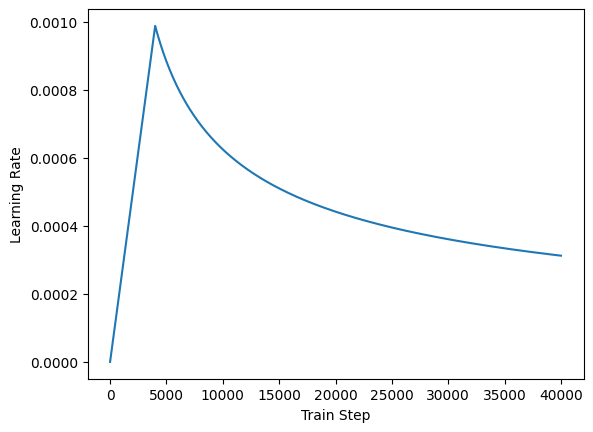

In [62]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [70]:
def masked_loss(label, pred):
    mask = label != pad_token_idx
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != pad_token_idx

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [71]:
seq2seq_model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [72]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_weights_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [73]:
%%time
seq2seq_model.fit(train_ds,
                validation_data=valid_ds,
                epochs=30,
                callbacks=[checkpoint_callback],
                verbose = 2)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
# with original preprocessing
Epoch 1/20

Epoch 1: val_loss improved from inf to 2.35214, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 140s - loss: 2.8293 - masked_accuracy: 0.2098 - val_loss: 2.3521 - val_masked_accuracy: 0.2946 - 140s/epoch - 111ms/step
Epoch 2/20

Epoch 2: val_loss improved from 2.35214 to 2.14052, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 64s - loss: 2.2375 - masked_accuracy: 0.3197 - val_loss: 2.1405 - val_masked_accuracy: 0.3471 - 64s/epoch - 51ms/step
Epoch 3/20

Epoch 3: val_loss improved from 2.14052 to 1.99580, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 2.0647 - masked_accuracy: 0.3680 - val_loss: 1.9958 - val_masked_accuracy: 0.3902 - 63s/epoch - 50ms/step
Epoch 4/20

Epoch 4: val_loss improved from 1.99580 to 1.87133, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.9208 - masked_accuracy: 0.4124 - val_loss: 1.8713 - val_masked_accuracy: 0.4291 - 62s/epoch - 49ms/step
Epoch 5/20

Epoch 5: val_loss improved from 1.87133 to 1.81366, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.8091 - masked_accuracy: 0.4461 - val_loss: 1.8137 - val_masked_accuracy: 0.4479 - 63s/epoch - 50ms/step
Epoch 6/20

Epoch 6: val_loss improved from 1.81366 to 1.73752, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.7284 - masked_accuracy: 0.4700 - val_loss: 1.7375 - val_masked_accuracy: 0.4709 - 62s/epoch - 49ms/step
Epoch 7/20

Epoch 7: val_loss improved from 1.73752 to 1.69962, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 65s - loss: 1.6629 - masked_accuracy: 0.4890 - val_loss: 1.6996 - val_masked_accuracy: 0.4828 - 65s/epoch - 51ms/step
Epoch 8/20

Epoch 8: val_loss improved from 1.69962 to 1.66101, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.6073 - masked_accuracy: 0.5053 - val_loss: 1.6610 - val_masked_accuracy: 0.4937 - 63s/epoch - 50ms/step
Epoch 9/20

Epoch 9: val_loss improved from 1.66101 to 1.63128, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.5573 - masked_accuracy: 0.5200 - val_loss: 1.6313 - val_masked_accuracy: 0.5025 - 63s/epoch - 50ms/step
Epoch 10/20

Epoch 10: val_loss improved from 1.63128 to 1.60701, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.5171 - masked_accuracy: 0.5324 - val_loss: 1.6070 - val_masked_accuracy: 0.5117 - 63s/epoch - 50ms/step
Epoch 11/20

Epoch 11: val_loss improved from 1.60701 to 1.58705, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.4777 - masked_accuracy: 0.5443 - val_loss: 1.5870 - val_masked_accuracy: 0.5172 - 62s/epoch - 49ms/step
Epoch 12/20

Epoch 12: val_loss improved from 1.58705 to 1.56979, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.4447 - masked_accuracy: 0.5538 - val_loss: 1.5698 - val_masked_accuracy: 0.5227 - 62s/epoch - 49ms/step
Epoch 13/20

Epoch 13: val_loss improved from 1.56979 to 1.55880, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.4123 - masked_accuracy: 0.5636 - val_loss: 1.5588 - val_masked_accuracy: 0.5274 - 60s/epoch - 47ms/step
Epoch 14/20

Epoch 14: val_loss improved from 1.55880 to 1.54515, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.3827 - masked_accuracy: 0.5725 - val_loss: 1.5452 - val_masked_accuracy: 0.5336 - 63s/epoch - 50ms/step
Epoch 15/20

Epoch 15: val_loss improved from 1.54515 to 1.53530, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.3567 - masked_accuracy: 0.5803 - val_loss: 1.5353 - val_masked_accuracy: 0.5369 - 63s/epoch - 50ms/step
Epoch 16/20

Epoch 16: val_loss improved from 1.53530 to 1.53161, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 59s - loss: 1.3317 - masked_accuracy: 0.5881 - val_loss: 1.5316 - val_masked_accuracy: 0.5390 - 59s/epoch - 47ms/step
Epoch 17/20

Epoch 17: val_loss improved from 1.53161 to 1.52362, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.3068 - masked_accuracy: 0.5955 - val_loss: 1.5236 - val_masked_accuracy: 0.5417 - 60s/epoch - 47ms/step
Epoch 18/20

Epoch 18: val_loss improved from 1.52362 to 1.51798, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 63s - loss: 1.2860 - masked_accuracy: 0.6025 - val_loss: 1.5180 - val_masked_accuracy: 0.5454 - 63s/epoch - 50ms/step
Epoch 19/20

Epoch 19: val_loss improved from 1.51798 to 1.51251, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 60s - loss: 1.2643 - masked_accuracy: 0.6088 - val_loss: 1.5125 - val_masked_accuracy: 0.5491 - 60s/epoch - 47ms/step
Epoch 20/20

Epoch 20: val_loss improved from 1.51251 to 1.51186, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 57s - loss: 1.2445 - masked_accuracy: 0.6156 - val_loss: 1.5119 - val_masked_accuracy: 0.5502 - 57s/epoch - 45ms/step
CPU times: user 21min 31s, sys: 1min 6s, total: 22min 38s
Wall time: 25min 40s
<keras.callbacks.History at 0x7ee928303850>

    Epoch 1/20

Epoch 1: val_loss improved from 1.51186 to 1.50952, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 64s - loss: 1.2251 - masked_accuracy: 0.6211 - val_loss: 1.5095 - val_masked_accuracy: 0.5535 - 64s/epoch - 51ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 1.50952
1263/1263 - 63s - loss: 1.2062 - masked_accuracy: 0.6273 - val_loss: 1.5155 - val_masked_accuracy: 0.5528 - 63s/epoch - 50ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.50952 to 1.50760, saving model to model_weights_checkpoint_128_128.h5
1263/1263 - 62s - loss: 1.1890 - masked_accuracy: 0.6328 - val_loss: 1.5076 - val_masked_accuracy: 0.5567 - 62s/epoch - 49ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1721 - masked_accuracy: 0.6376 - val_loss: 1.5102 - val_masked_accuracy: 0.5574 - 62s/epoch - 49ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1571 - masked_accuracy: 0.6425 - val_loss: 1.5159 - val_masked_accuracy: 0.5569 - 62s/epoch - 49ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1408 - masked_accuracy: 0.6472 - val_loss: 1.5198 - val_masked_accuracy: 0.5572 - 62s/epoch - 49ms/step
Epoch 7/20

Epoch 7: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1262 - masked_accuracy: 0.6521 - val_loss: 1.5226 - val_masked_accuracy: 0.5587 - 62s/epoch - 49ms/step
Epoch 8/20

Epoch 8: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.1131 - masked_accuracy: 0.6558 - val_loss: 1.5269 - val_masked_accuracy: 0.5590 - 62s/epoch - 49ms/step
Epoch 9/20

Epoch 9: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0978 - masked_accuracy: 0.6608 - val_loss: 1.5258 - val_masked_accuracy: 0.5607 - 62s/epoch - 49ms/step
Epoch 10/20

Epoch 10: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0859 - masked_accuracy: 0.6638 - val_loss: 1.5242 - val_masked_accuracy: 0.5618 - 62s/epoch - 49ms/step
Epoch 11/20

Epoch 11: val_loss did not improve from 1.50760
1263/1263 - 61s - loss: 1.0745 - masked_accuracy: 0.6676 - val_loss: 1.5398 - val_masked_accuracy: 0.5594 - 61s/epoch - 48ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 1.50760
1263/1263 - 60s - loss: 1.0619 - masked_accuracy: 0.6717 - val_loss: 1.5361 - val_masked_accuracy: 0.5614 - 60s/epoch - 47ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0496 - masked_accuracy: 0.6761 - val_loss: 1.5410 - val_masked_accuracy: 0.5623 - 62s/epoch - 49ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 1.0391 - masked_accuracy: 0.6787 - val_loss: 1.5386 - val_masked_accuracy: 0.5626 - 59s/epoch - 47ms/step
Epoch 15/20

Epoch 15: val_loss did not improve from 1.50760
1263/1263 - 61s - loss: 1.0295 - masked_accuracy: 0.6817 - val_loss: 1.5450 - val_masked_accuracy: 0.5620 - 61s/epoch - 48ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 1.0198 - masked_accuracy: 0.6849 - val_loss: 1.5536 - val_masked_accuracy: 0.5637 - 59s/epoch - 47ms/step
Epoch 17/20

Epoch 17: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 1.0100 - masked_accuracy: 0.6871 - val_loss: 1.5522 - val_masked_accuracy: 0.5642 - 62s/epoch - 49ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 1.50760
1263/1263 - 63s - loss: 1.0012 - masked_accuracy: 0.6905 - val_loss: 1.5506 - val_masked_accuracy: 0.5655 - 63s/epoch - 50ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 1.50760
1263/1263 - 59s - loss: 0.9902 - masked_accuracy: 0.6934 - val_loss: 1.5606 - val_masked_accuracy: 0.5644 - 59s/epoch - 47ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 1.50760
1263/1263 - 62s - loss: 0.9826 - masked_accuracy: 0.6959 - val_loss: 1.5640 - val_masked_accuracy: 0.5640 - 62s/epoch - 49ms/step

In [227]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = seq2seq_model((test_inp, test_ctx))
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
num_to_char[pred_idx]

'_'

# Save model

In [228]:
tf_chars = tf.constant(list(char_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(char_to_num.values()), dtype=tf.int64)

class Seq2SeqModel(tf.Module):
    def __init__(self, model):
        super(Seq2SeqModel, self).__init__()
        self.model = model
        
        self.tf_char_to_num = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_chars,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_char_to_num_lut"
        )
        
        self.tf_num_to_char = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_nums,
                values=tf_chars,
            ),
            default_value=tf.constant("unknown", dtype=tf.string),
            name="tf_num_to_char_lut"
        )

        self.ctx_len = tf.constant(max_future_input_size, dtype=tf.int32)

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[tf.constant(FRAME_LEN), tf.constant(lm_shape)], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.string), # The input string is trimmed to max size set when initializing model
    ])
    def predict(self, landmarks, ctx):
        # Prepare input
        ctx_length = tf.strings.length(ctx)
        starting_pos = tf.maximum(ctx_length - self.ctx_len, 0)
        ctx = tf.strings.substr(ctx, starting_pos, self.ctx_len)
        
        ctx_chars = tf.strings.unicode_split(ctx, input_encoding='UTF-8')
        ctx_tokens = self.tf_char_to_num.lookup(ctx_chars)
        batched_ctx_tokens = tf.expand_dims(ctx_tokens, axis=0) # Adds first ("batch") dimension to the tensor
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model((batched_landmarks, batched_ctx_tokens), training=False)
        logits = logits[:, -1:, :][0][0] # Select the last element in the middle dimension (the first is the batch dim, the last is the num_of_classes dim)
        
        # Parse result
        probabilities = tf.nn.softmax(logits)
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_char = self.tf_num_to_char.lookup(pred_idx)
        
        return {'result' : pred_char, 'confidence': pred_prob}

In [229]:
model_wrapper = Seq2SeqModel(seq2seq_model)

In [231]:
%%time
model_wrapper.predict(np.zeros((FRAME_LEN, lm_shape)), "abc")

CPU times: total: 219 ms
Wall time: 57 ms


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'd'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.024407035>}

Note: first time execution is usually slower than the rest.

In [232]:
save_model_name = "saved_model"
if os.path.isdir(save_model_name):
    print(f"A model with the same name has already been saved!")
else:
    tf.saved_model.save(model_wrapper, export_dir=save_model_name)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


# Load model

## From saved weights

1. Create model object with same parameters
2. Build the model (run inference on it, to initialize the parameters)
3. Load the weights
4. Convert it to tf.Module or run manual inference on it

In [233]:
new_model = get_model()

In [234]:
# Example inference to build the model
(lm, ctx), _label = next(iter(train_ds))
output = new_model((lm, ctx))

print(lm.shape)
print(ctx.shape)
print(output.shape)

new_model.summary()

(32, 256, 108)
(32, 33)
(32, 33, 62)
Model: "seq2_seq_recurrent_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding_3 (Land  multiple                  1746688   
 markEmbedding)                                                  
                                                                 
 dropout_54 (Dropout)        multiple                  0         
                                                                 
 positional_token_embedding  multiple                  15872     
 _27 (PositionalTokenEmbedd                                      
 ing)                                                            
                                                                 
 dropout_55 (Dropout)        multiple                  0         
                                                                 
 gru_26 (GRU)                multiple                  394752    
        

In [94]:
new_model.load_weights("model_weights_checkpoint.h5")

In [96]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
test_ctx = np.array([[start_token_idx]])
logits = new_model((test_inp, test_ctx), training=False)
logits = logits[:, -1:, :][0][0]
pred_idx = np.argmax(tf.nn.softmax(logits))
num_to_char[pred_idx]

'm'

In [97]:
loaded_model = FingerSpellingTransformer(new_model)

In [98]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'm'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.09073451>}

## From saved model

In [235]:
loaded_model = tf.saved_model.load("saved_model")

In [236]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)), "<")

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'_'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.02006547>}

## On Test dataset

In [107]:
def generate(fs_model, inp, max_len):
    ctx = str(num_to_char[start_token_idx])
    for i in range(max_len):
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        ctx += res_char

        if res_char == num_to_char[end_token_idx]:
            break
    return ctx

def generate_teacher_forcing(fs_model, inp, expected):
    pred = str(num_to_char[start_token_idx])
    ctx = str(num_to_char[start_token_idx])
    for e in expected:
        if e == 'P':
            break
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        pred += res_char
        ctx += e
    return pred

In [108]:
(inp_batch, _ctx), expected_batch = random.choice([batch for batch in valid_ds])
for seq, expected in zip(inp_batch, expected_batch):
    expected = "".join([num_to_char[num.numpy()] for num in expected])

    print("Expected: " + expected)
    print("Gen on own: " + generate(loaded_model, seq, MAX_PHRASE_LEN))
    print("Gen teacher forcing: " + generate_teacher_forcing(loaded_model, seq, expected))
    print('\n~~~\n')

Expected: golfcourseweddings>PPPPPPPPPPPPP
Gen on own: <+61-05-206-18>
Gen teacher forcing: <+obf-rtro wodey>g..

~~~

Expected: 9396 yuchi lane>PPPPPPPPPPPPPPPP
Gen on own: <93396 yuchi lane>
Gen teacher forcing: <9336 yuchi lane>

~~~

Expected: 506-993-4525>PPPPPPPPPPPPPPPPPPP
Gen on own: <506-993-4525>
Gen teacher forcing: <506-993-4525>

~~~

Expected: 428823 winter house>PPPPPPPPPPPP
Gen on own: <428823 winter horse>
Gen teacher forcing: <428823 winter horse>

~~~

Expected: america_2>PPPPPPPPPPPPPPPPPPPPPP
Gen on own: <anmrica.12>
Gen teacher forcing: <anrrica.1>

~~~

Expected: 628-137-7392>PPPPPPPPPPPPPPPPPPP
Gen on own: <628-137-7392>
Gen teacher forcing: <628-137-7392>

~~~

Expected: 370 ivy spring>PPPPPPPPPPPPPPPPP
Gen on own: <370 vys pring>
Gen teacher forcing: <370 vvy spring>

~~~

Expected: 889-022-9065>PPPPPPPPPPPPPPPPPPP
Gen on own: <889-022-9065>
Gen teacher forcing: <889-022-9065>

~~~

Expected: ronnie simon>PPPPPPPPPPPPPPPPPPP
Gen on own: <randie orraie>
Gen tea

## Real life testing

### Util for handling video feed

In [165]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

In [166]:
def extract_from_result(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

In [167]:
def video_loop(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
            while True:
                _, frame = video.read()
    
                if frame is None:
                    break
    
                #image = cv2.resize(frame, (360, 240))
                image=frame
    
                # To improve performance, optionally mark the image as not writeable to pass by reference.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = holistic.process(image)
                data = extract_from_result(results)

                process_data_func(data)
    
                # Draw landmark annotation on the image.
                image = draw_landmarks_on_image(image, results)
    
                image = cv2.flip(image, 1)
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

### Util for handling models

#### Signing detector

In [272]:
# Only load once
signing_detection_model = tf.saved_model.load("signing_detection_model")

class SigningDetectionModel:
    def __init__(self):
        self.signing_detection_model_input = list(np.zeros((15, 156)))

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        return signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy() == 1

class BufferedSigningDetectionModel:
    def __init__(self, buffer_len=5, confidence_number=3):
        self.signing_detection_model_input = list(np.zeros((15, 156)))
        self.signing_detector_buffer = deque(maxlen=buffer_len)
        self.confidence_number = confidence_number 

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        pred = signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy()
        self.signing_detector_buffer.append(pred)
        buffered_pred, count = Counter(self.signing_detector_buffer).most_common(1)[0]
        if count >= self.confidence_number:
            return buffered_pred == 1
        else:
            return False

#### Fingerspelling recognition models

In [300]:
# Only load once
loaded_transformer_model = loaded_model

class ContinuousRecognitionModel:
    def __init__(self, confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7):
        self.input = []
        self.trust_confidence = confidence_threshold
        self.inp_len = inp_buf_len
        self.inner_fifo = deque(maxlen=out_buf_len)
        self.confidence_number = out_majority_threshold
        self.context = str(num_to_char[start_token_idx])

    def process_frame(self, frame):
        if len(self.input) >= self.inp_len:
            self.input.pop(0)
        self.input.append(frame)
    
        inp = pre_process(self.input)
        res = loaded_transformer_model.predict(inp, self.context)
        pred = res["result"].numpy().decode("utf-8")
        prob = res["confidence"].numpy()

        if prob < self.trust_confidence:
            return

        self.inner_fifo.append(pred)
        pred_char, count = Counter(self.inner_fifo).most_common(1)[0]
        if count >= self.confidence_number:
            if self.context[-1] != pred_char:
                self.context += pred_char
                print(pred_char, end="")
                
                # Predicted the end
                if pred_char == '>':
                    # restart the detection
                    self.context = str(num_to_char[start_token_idx])
                    self.inner_fifo.clear()
                    self.input.clear()

class NonContinuousRecognitionModel:
    def __init__(self, max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2):
        self.max_out_length = max_out_length
        self.max_input_length = max_input_length
        self.confidence_threshold = confidence_threshold
        self.input = []

    def reset_buffer(self):
        self.input.clear()

    def translate_buffered_content(self, reset_buffer=False):
        if len(self.input) > 0:
            inp = pre_process(self.input)
            print(self._generate_with_confidence(inp))
        if reset_buffer:
            self.reset_buffer()

    def process_frame(self, inp_lm):
        self.input.append(inp_lm)
        
        if len(self.input) >= FRAME_LEN:
            self.translate_buffered_content()
            self.reset_buffer()

    def _generate_with_confidence(self, inp):
        ctx = str(num_to_char[start_token_idx])
        for i in range(self.max_out_length):
            res = loaded_model.predict(inp, ctx)
            res_char = res["result"].numpy().decode("utf-8")
            prob = res["confidence"].numpy()
            if prob > self.confidence_threshold:
                ctx += res_char
                if res_char == num_to_char[end_token_idx]:
                    break
        return ctx

### Running diffrent configurations

#### Continuous model without signing detection

Works well for isolated sequences. Can't handle sudden pauses, and stops.
Extremely sensitive to window size. Also, the training data was from professional signers. For beginners who sign slower the same window size isn't suitable.

In [302]:
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))

None

beark

#### Continuous model with signing detection

Handles breaks at the start and end, but doesn't account for breaks mid-signing, or multiple words, as the model's buffer is only filled when signing is detected. This can lead to jumps in the buffer data.

In [303]:
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)

def process_data(data):
    if sign_detector.is_signing(data):
        print("*", end="")
        fs_model.process_frame(data)
    else:
        print("-", end="")

video_loop("test_videos/alligator.mp4", process_data)

None

--------------*******************************--------*********a*******l*******************************i*******g*******a*******t*******o*******r*******>--------------*****

In [ ]:
# TODO model that takes input frames all the time but only predicts when signing is detected!!!!!
# Continue the train of thought for the rest!!!

#### Translate in long chunks

This model performs well on single words that fit into the buffer. But for longer text it fails to translate well, presumable because the signs are cut off at the wrong positions. For longer text pause detection/signing detection is needed.

In [310]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))
fs_model.translate_buffered_content()

None

<beark>


#### Translate in long chunks  with signing detection

In [307]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)

video_loop("test_videos/monkey.mp4", process_data)
fs_model.translate_buffered_content()

None

<monkey >


#### Translate longer sequences with stops

In [308]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)
    else:
        fs_model.translate_buffered_content(reset_buffer=True)

video_loop("test_videos/fingerspelling_animals.mp4", process_data)
fs_model.translate_buffered_content()

None

<earkn>
<
<tigerr>
<
<ebraa>
<
<yena>
<
<angaroo hangaroo>
<monkey >
<
<lyonn parks>
<s
<alligator>
<horse horse>
<


In [225]:
%%capture
!pip install openai

In [226]:
import openai

In [233]:
key = os.environ.get('OPEN_AI_API_KEY')
if key is not None:
    openai.api_key = key
else:
    print("Error: Please set a valid api key!")

Error: Please set a valid api key!


In [242]:
def correct_output(pred):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. Some letters might be missing, but it's also possible that the given text has extra characters. Only reply the corrected text."},
        {"role": "user", "content": "angaro angaro"},
        {"role": "system", "content": "kangaroo"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "bear"},
        {"role": "user", "content": "6 halee hale"},
        {"role": "system", "content": "whale"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [251]:
correct_output("earkh/tiger/tiger angar key ligator alligator h horse gro")

'earth/tiger/angary ligator alligator horse gro'